# CC5215: Privacidad de Datos
## Proyecto grupal - Entregable 3

## Miembros del grupo

Ingrese los nombres de lxs miembros del grupo. Recuerde que el grupo debe tener un máximo de 3 miembros y la constitución del grupo **no se puede cambiar** a lo largo de los distintos entregables.

*   Miembro 1: Romina Rodriguez
*   Miembro 2: Jorge Barraza
*   Miembro 3: Diego Pizarro


## Objetivo general
El objetivo de esta entrega es que apliquen técnicas de privacidad diferencial para publicar datos sintéticos. Para ello, primero vamos a calcular el tamaño completo de su dominio de atributos posibles. Dado que los algoritmos de síntesis presentan dificultades para escalar bien con respecto el tamaño del espacio de los atributos, vamos a probar distintas abstracciones para comprimir el espacio y posteriormente evaluar la calidad de la síntesis.

## Reglas

* El documento debe ser **autocontenido** y debe explicar para cada atributo si es númerico o categórico.
* En esta entrega se evaluarán minuciosamente los razonamientos seguidos, y los argumentos detrás de ellos. Justifique lo mejor que pueda cada paso de sus análisis.
* Con el fin de poder evaluar objetivamente sus resultados, su entrega debe indicar **todos** los pasos que siguió (incluyendo los "malos" pasos), especialmente del código.
* Siéntase libre de agregar bloques de código o texto según los necesite. Sin embargo, se le recomienda mantener un mínimo orden en su entrega final.



In [1]:
# Utils

import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
from itertools import product
import time

plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

<ipython-input-1-775c66ddc3ad>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## P0 (0 puntos)

Cargue su dataset, listo para usarse, y describa cada columna (que vaya a sintétizar), indicando si el atributo es numérico o categórico. Tome las siguientes consideraciones:
- Elimine, si corresponde, todas las columnas que no vaya a usar en su entrega.
- Seleccione al menos 4 atributos significativas para posteriores análisis.
- Considere al menos un atributo númerico y uno categórico si corresponde.

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/dpizarrow/CC5215-Project/main/Juvenile_Arrests.csv?token=GHSAT0AAAAAAB2DIKKZXN6YFQNBSSKJYWYCZBTNAOA')

In [3]:
print("Largo de dataset original:", len(dataset))
cols_to_keep = [
    'Charge',
    'Date Arrested',
    'Age',
    'Arrest Description'
]
dataset = dataset[cols_to_keep]
dataset = dataset.dropna()
dataset = dataset.reset_index(drop = True)

# Se verifica que no existan nulos
print("Nulos:", dataset.isna().sum())
print("Largo de dataset actual:", len(dataset))

print("Únicos:",dataset.nunique())

Largo de dataset original: 2938
Nulos: Charge                0
Date Arrested         0
Age                   0
Arrest Description    0
dtype: int64
Largo de dataset actual: 2759
Únicos: Charge                 619
Date Arrested         1229
Age                     10
Arrest Description       5
dtype: int64


- Con el fin de poder ejecutar los algoritmos de datos sinteticos sin tener problemas de memoria, una decision de que se tomara es quedarse con los top 5 cargos mas frecuentes, eliminando entradas que no tienen algun cargo dentro del listado.

In [4]:
top_5_charges = dataset['Charge'].value_counts()[:5].sort_values(ascending=True)
top_5_charges = [index for index, _ in top_5_charges.iteritems()]
top_5_charges

<ipython-input-4-5ddaf343a46a>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  top_5_charges = [index for index, _ in top_5_charges.iteritems()]


['BURGL-STRUCTURE UNOCCUPIED/UNARMED',
 'RESIST OFFICER-OBSTRUCT WO VIOLENCE',
 'BURGL-DWELLING UNOCCUPIED/UNARMED',
 'BURGL-CONVEYANCE UNOCCUPIED/UNARMED',
 'VEH THEFT-GRAND THEFT OF MOTOR VEHICLE']

In [5]:
dataset = dataset[dataset['Charge'].isin(top_5_charges)]
print("Largo de dataset con cargos pertenencientes al top 5:", len(dataset))
print("Únicos:", dataset.nunique())

Largo de dataset con cargos pertenencientes al top 5: 894
Únicos: Charge                  5
Date Arrested         487
Age                     8
Arrest Description      4
dtype: int64


El dataset corresponde a arrestos de juveniles en la ciudad de Fort Lauderdale, Florida, EEUU. Contine 2600 datos de arrestos luego de la limpieza del dataset. Estos datos fueron obtenidos de la pagina Fort Lauderdale Police Department - Open Data Portal, y la ultima actualización fue el año 2020.

Las columnas resultantes posterior a la limpieza son:

- Charge (categórico): Motivo del arresto
- Date Arrested (numérico): Fecha del arresto
- Age (numérico): Edad de la persona arrestada
- Arrest Description (categórico): Descripción del arresto

## P1 (5 puntos)

Sea $\mathbf{x} = (x_1, ..., x_d)$ una fila de su conjunto de datos, donde $x_i$ es el atributo $i$-ésimo que pertenece al dominio finito discreto $\mathcal{X}_i$ de $n_i$ posibles valores.
El dominio completo es $\mathcal{X} = \prod^d_{i=1} \mathcal{X}_i$ y su tamaño $n = \prod^d_{i=1} n_i$ es exponencial en el número de atributos.
Un conjunto de datos $\mathbf{X}$ consiste en $m$ de esas filas $\mathbf{X} = (\mathbf{x}^{(1)}, ..., \mathbf{x}^{(m)})$.

- Calcule  el $n$ que corresponde al tamaño de su dominio completo.


In [6]:
def calc_n(dataset):
  n = 1

  for col in dataset.columns:
    n *= dataset[col].nunique()

  return n

calc_n(dataset)

77920

## P2 (10 puntos)

Presente dos tablas de contigencia $p$, usando distintas técnicas de abstracción/compresión de los datos para reducir la dimencionalidad de $n$. Para ello:
1. Elija dos niveles de abstracciones decrecientes
2. Para cada nivel de abstracción:
  - Describa la abstraccion elegida y calcule su $n$.
  - Construya la *tabla de contingencia normalizada* asociada a dicha abstracción.
  Una tabla de contigencia normalizada $p$ se define como $\forall x \in \mathcal{X}, p(x) = \frac{1}{m}\sum_{i=1}^m \mathbb{I}\{x^{(i)} = x\}$, donde $\mathbb{I}\{x = v\}$ es 1 si $x = v$, 0 si no.

Se trabajaran con las siguientes abstracciones:

1. Particionar la columna Age en intervalos, modificando cada edad a la cota inferior del intervalo:
  - 0 - 8 años
  - 9 - 11 años
  - 12 - 15 años
  - 16 - 18 años

Ademas de esto se agrupa la columna Date Arrested segun mes y año

2. Solamente modificar la columna Date Arrested para agruparlas segun mes y año, para que cada fecha sea mes/año

In [7]:
# Abstraccion 1

dataset_1 = dataset.copy()

def map_ages(age):
  if age <= 8: return 0
  elif age <= 11: return 8
  elif age <= 15: return 12
  else: return 16

dataset_1['Age'] = dataset_1['Age'].map(map_ages)
dataset_1['Date Arrested'] = dataset_1['Date Arrested'].str.split().str[0]
dataset_1['Date Arrested'] = dataset_1['Date Arrested'].str.split('/').str[0] + '/' + dataset_1['Date Arrested'].str.split('/').str[2]
calc_n(dataset_1)

3720

In [8]:
columns = list(dataset_1.columns)
D_1 = pd.merge(pd.DataFrame(list(product(*[dataset_1[col].unique() for col in columns])), columns=columns),
         dataset_1, left_on=columns, right_on=columns, how="left").fillna(0).groupby(columns)['Age'].size().reset_index(name='counts')
D_1['counts'] = D_1['counts'] / D_1['counts'].sum()
D_1

,Charge,Date Arrested,Age,Arrest Description,counts
0,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,8,OUT OF CUSTODY,0.000238
1,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,8,PHYSICAL / IN CUSTODY,0.000238
2,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,8,TRAFFIC,0.000238
3,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,8,WARRANT,0.000238
4,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,12,OUT OF CUSTODY,0.000238
...,...,...,...,...,...
3715,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,12,WARRANT,0.000238
3716,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,OUT OF CUSTODY,0.000238
3717,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,PHYSICAL / IN CUSTODY,0.000238
3718,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,TRAFFIC,0.000238


In [9]:
D_1_f = D_1.copy()

In [10]:
D_1['counts'].nunique()

11

In [11]:
# Abstraccion 2

dataset_2 = dataset.copy()

dataset_2['Date Arrested'] = dataset_2['Date Arrested'].str.split().str[0]
dataset_2['Date Arrested'] = dataset_2['Date Arrested'].str.split('/').str[0] + '/' + dataset_2['Date Arrested'].str.split('/').str[2]

calc_n(dataset_2)

9920

In [12]:
columns = list(dataset_2.columns)
D_2 = pd.merge(pd.DataFrame(list(product(*[dataset_2[col].unique() for col in columns])), columns=columns),
         dataset_2, left_on=columns, right_on=columns, how="left").fillna(0).groupby(columns)['Age'].size().reset_index(name='counts')
D_2['counts'] = D_2['counts'] / D_2['counts'].sum()
D_2

,Charge,Date Arrested,Age,Arrest Description,counts
0,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,OUT OF CUSTODY,0.000098
1,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,PHYSICAL / IN CUSTODY,0.000098
2,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,TRAFFIC,0.000098
3,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,WARRANT,0.000098
4,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,11.0,OUT OF CUSTODY,0.000098
...,...,...,...,...,...
9915,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16.0,WARRANT,0.000098
9916,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,17.0,OUT OF CUSTODY,0.000098
9917,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,17.0,PHYSICAL / IN CUSTODY,0.000098
9918,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,17.0,TRAFFIC,0.000098


## P3 (20 puntos)

Para cada $n$ obtenido en la pregunta anterior:
- Utilice los dos algoritmos vistos en clase de síntesis de datos,  para generar $\widetilde{p}$, una versión sintética de $p$. Para MWEM prueben distintos conjuntos de consultas $Q$ hasta tener un nivel de útilidad aceptable (ver próxima pregunta). Recuerde que su código debe mostrar tanto los resultados "buenos" como los "malos", con el fin de justificar sus decisiones finales.
- Pruebe distintos valores de $\epsilon$ $(0.1, 1, 10, 100)$. Siéntase libre de probar otros valores de $\epsilon$ que considere útiles.

## Algoritmo Naive

In [13]:
def range_query(df, col, a, b):
  return len(df[(df[col] >= a) & (df[col] < b)])

In [14]:
bins = list(range(0, 18))
counts = [range_query(D_1, 'Age', b, b+1) for b in bins]

In [15]:
def range_query_from_synop(synop, a, b):
  total = 0
  for i in range(a, b):
    total += synop[i]
  return total

In [16]:
epsilon = 1
dp_syn_rep = [laplace_mech(c, 1, epsilon) for c in counts]

In [17]:
print(range_query_from_synop(counts, 12, 18))
print(range_query_from_synop(dp_syn_rep, 12, 18))

2480
2481.542901020798


In [18]:
dp_syn_rep_nn = np.clip(dp_syn_rep, 0, None)
syn_normalized = dp_syn_rep_nn / np.sum(dp_syn_rep_nn)

In [19]:
def gen_samples(n):
  return np.random.choice(bins, n, p=syn_normalized)

syn_data = pd.DataFrame(gen_samples(len(D_1)), columns=['Age'])
syn_data

,Age
0,16
1,8
2,16
3,8
4,16
...,...
3715,12
3716,16
3717,8
3718,16



## Algoritmo MWEM

In [20]:
# QUERIES

def gen_queries(D, D2):

  q_list = []
  ages = list(range(0, 19))
  descs = list(D2['Arrest Description'].unique())
  charges = list(D2['Charge'].unique())
  dates = ['2015', '2016', '2017', '2018', '2019', '2020']


  for a in ages:
    for d in descs:
      q_list.append(((D['Age'] >= a) & (D['Arrest Description'] == d)).astype(int))

  for d in dates:
    for c in charges:
      q_list.append(((d in D['Date Arrested']) & (D['Charge'] == c)).astype(int))

  Qs = []
  for q in q_list:
    Qs.append((q, lambda s: (q * s).sum()))
  return Qs

In [21]:
# MWEM

def gen_first_guess(D):
  Dp = D.copy()
  Dp['counts'] = 1.0 / Dp.shape[0]
  return Dp
D0_1 = gen_first_guess(D_1)

In [22]:
def get_i_max_nonDP(D, D_prev, queries):
    """
    Determine the index of the maximum query based on the absolute difference of query results.

    Parameters:
        D (pandas.DataFrame): The input data.
        D_prev (pandas.DataFrame): The previous distribution.
        queries (list): List of queries to compare.

    Returns:
        int: The index of the maximum query.
    """

    errors = [abs(Q(D) - Q(D_prev)) for _, Q in queries]
    i_max = np.argmax(errors)

    return i_max

In [23]:
def exponential(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]

    # Calculate the probability for each element, based on its score
    probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]

    # Normalize the probabilties so they sum to 1
    probabilities = probabilities / np.linalg.norm(probabilities, ord=1)

    # Choose an element from R based on the probabilities
    return np.random.choice(R, 1, p=probabilities)[0]

In [24]:
def MWEM(D, queries, iterations, epsilon):
    """
    Perform the Multiplicative Weights Exponential Mechanism (MWEM) algorithm.

    Parameters:
        D (pandas.DataFrame): The input data.
        queries (list): List of queries to be performed in each iteration.
            #Each query is a tuple containing the query function and its associated query data.
        iterations (int): Number of iterations to perform.

    Returns:
        pandas.DataFrame: The final result after performing the MWEM iterations.
    """

    D0 = gen_first_guess(D)
    S0 = D0['counts']

    Ds = [S0]
    sum = S0

    eps = epsilon/(2.0*iterations)

    for i in range(iterations):
        D_prev = Ds[-1]

        def score(DD, j):
          _, Q = queries[j]
          return abs(Q(DD) - Q(D_prev))

        #i_max = get_i_max_nonDP(D, D_prev, queries)
        i_max = exponential(D, range(len(queries)), score, 1, eps)
        (query_max, Query_max) = queries[i_max]
        #print(i_max)

        #correction = Query_max(D) - Query_max(D_prev)
        correction = laplace_mech(Query_max(D), 1, eps) - Query_max(D_prev)
        #print(correction)

        D_i = D_prev * np.exp(query_max * correction / 2)
        aux = D_i / D_i.values.sum()
        Ds.append(aux)
        sum += aux

    result = sum / iterations

    return result / result.values.sum()

Una vez que se ejecuta MWEM, se toma la columna counts y se desnormaliza. Luego se redondea cada valor de count a un entero. Esto se hace para repetir cada entrada segun su valor, generando finalmente la data sintetica.

In [25]:
def run_trials(epsilons, df_orig, queries, iters):
  df = df_orig.copy()
  lista = []
  for e in epsilons:
    t0 = time.time()
    print(f'Using epsilon {e}')
    res = MWEM(df['counts'], queries, iters, e)
    res = res.apply(lambda x: x * len(res))
    df['counts'] = res
    df['counts'] = df['counts'].apply(lambda x: round(x))
    res_syn = df.loc[res.index.repeat(df['counts'])].reset_index(drop=True)
    res_syn['counts'] = 1 / len(res_syn['counts'])
    tf = time.time()
    print(f'Epsilon {e} took {round(tf - t0, 2)} seconds')
    lista.append(res_syn)
  return lista

In [26]:
epsilons = [1, 10, 25, 50, 100]
Qs_1 = gen_queries(D_1, D_1)
syn_dfs_1 = run_trials(epsilons, D_1, Qs_1, 100)

syn_dfs_1[0]

Using epsilon 1
Epsilon 1 took 14.02 seconds
Using epsilon 10
Epsilon 10 took 13.3 seconds
Using epsilon 25
Epsilon 25 took 8.6 seconds
Using epsilon 50
Epsilon 50 took 5.12 seconds
Using epsilon 100
Epsilon 100 took 6.24 seconds


,Charge,Date Arrested,Age,Arrest Description,counts
0,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,8,WARRANT,0.000293
1,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,12,WARRANT,0.000293
2,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,16,PHYSICAL / IN CUSTODY,0.000293
3,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,16,PHYSICAL / IN CUSTODY,0.000293
4,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,16,PHYSICAL / IN CUSTODY,0.000293
...,...,...,...,...,...
3405,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,PHYSICAL / IN CUSTODY,0.000293
3406,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,PHYSICAL / IN CUSTODY,0.000293
3407,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,PHYSICAL / IN CUSTODY,0.000293
3408,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,PHYSICAL / IN CUSTODY,0.000293


In [27]:
syn_dfs_1[2]

,Charge,Date Arrested,Age,Arrest Description,counts
0,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,8,WARRANT,0.000269
1,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,12,OUT OF CUSTODY,0.000269
2,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,12,OUT OF CUSTODY,0.000269
3,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,12,OUT OF CUSTODY,0.000269
4,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,12,OUT OF CUSTODY,0.000269
...,...,...,...,...,...
3715,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,OUT OF CUSTODY,0.000269
3716,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,OUT OF CUSTODY,0.000269
3717,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,OUT OF CUSTODY,0.000269
3718,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,16,OUT OF CUSTODY,0.000269


In [28]:
Qs_2 = gen_queries(D_2, D_2)
syn_dfs_2 = run_trials(epsilons, D_2, Qs_2, 100)
syn_dfs_2[0]

Using epsilon 1
Epsilon 1 took 5.83 seconds
Using epsilon 10
Epsilon 10 took 6.64 seconds
Using epsilon 25
Epsilon 25 took 5.55 seconds
Using epsilon 50
Epsilon 50 took 6.6 seconds
Using epsilon 100
Epsilon 100 took 5.48 seconds


,Charge,Date Arrested,Age,Arrest Description,counts
0,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,PHYSICAL / IN CUSTODY,0.000104
1,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,PHYSICAL / IN CUSTODY,0.000104
2,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,PHYSICAL / IN CUSTODY,0.000104
3,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,9.0,PHYSICAL / IN CUSTODY,0.000104
4,BURGL-CONVEYANCE UNOCCUPIED/UNARMED,01/2016,12.0,OUT OF CUSTODY,0.000104
...,...,...,...,...,...
9605,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,17.0,TRAFFIC,0.000104
9606,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,17.0,TRAFFIC,0.000104
9607,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,17.0,TRAFFIC,0.000104
9608,VEH THEFT-GRAND THEFT OF MOTOR VEHICLE,12/2019,17.0,TRAFFIC,0.000104


## P4 (20 puntos)

Para cada tabla sintética generada en el ítem anterior mida su útilidad y tiempo de ejecución.
- No es necesario que corran el algorítmo de síntesis múltiples veces.
- Para medir la útilidad utilice distintas métricas como (justifique la elección de su métrica):
  - $L(p) = || Q(p) - Q(\widetilde{p})||_1$
  - $||p - \widetilde{p}||_1$
- Por cada medición de utilidad, grafique el nivel de utilidad (o error) vs privacidad.

Como se pueden ver en las celdas anteriores, se tienen los siguientes tiempos de ejecucion para el MWEM en las dos abstracciones:

**Abstraccion 1**

| Epsilon | Tiempo de ejecucion (s) |
|---------|-------------------------|
| 1       | 3.88                    |
| 10      | 4.16                    |
| 25      | 4.33                    |
| 50      | 3.83                    |
| 100     | 3.99                    |

**Abstraccion 2**

| Epsilon | Tiempo de ejecucion (s) |
|---------|-------------------------|
| 1       | 5.21                    |
| 10      | 4.47                    |
| 25      | 5.13                    |
| 50      | 4.37                    |
| 100     | 4.39                    |

Para las distintas abstracciones, se usara ademas la metrica

$$
L(p) = || Q(p) - Q(\widetilde{p})||_1
$$

Para medir la utilidad de la data sintetica. Es conveniente utilizar esta metrica ya que con las queries que se hicieron se puede medir facilmente la diferencia absoluta entre los resultados de las queries entre la tabla original y la sintetica. Como hay 107 queries para cada $\epsilon$, se tomara un promedio de los errores para cada epsilon, mostrandolos todos en un grafico.

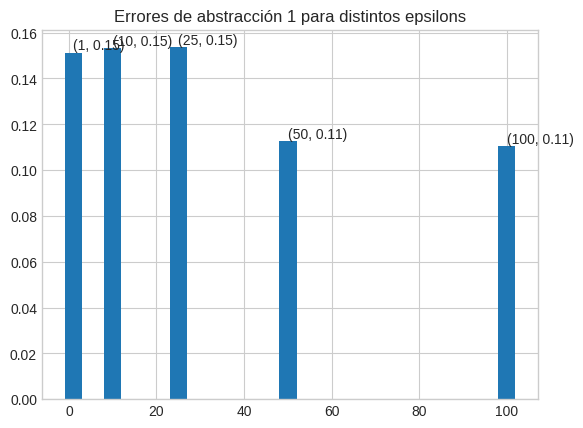

In [29]:
avgs = []
epsilons = [1, 10, 25, 50, 100]

for df in syn_dfs_1:
  errors = []
  Qs_1_syn = gen_queries(df, D_1)
  for i in range(len(Qs_1)):
    e = abs((Qs_1[i][0] * D_1['counts']).sum() - (Qs_1_syn[i][0] * df['counts']).sum())
    errors.append(e)
  avgs.append(np.mean(errors))

plt.bar(epsilons, avgs, width=4)
plt.title('Errores de abstracción 1 para distintos epsilons')
for i, j in zip(epsilons, avgs):
    plt.text(i, j, f'({i}, {round(j, 2)})', ha='left', va='bottom')

plt.show()

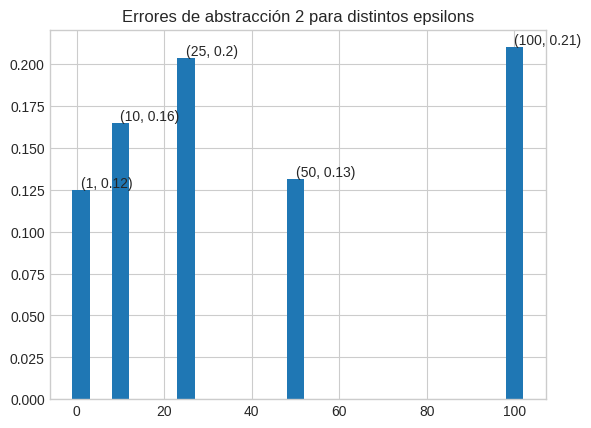

In [30]:
avgs = []
epsilons = [1, 10, 25, 50, 100]

for df in syn_dfs_2:
  errors = []
  Qs_2_syn = gen_queries(df, D_2)
  for i in range(len(Qs_2)):
    e = abs((Qs_2[i][0] * D_2['counts']).sum() - (Qs_2_syn[i][0] * df['counts']).sum())
    errors.append(e)
  avgs.append(np.mean(errors))

plt.bar(epsilons, avgs, width=4)
plt.title('Errores de abstracción 2 para distintos epsilons')
for i, j in zip(epsilons, avgs):
    plt.text(i, j, f'({i}, {round(j, 2)})', ha='left', va='bottom')

plt.show()

Viendo ambos graficos podemos decir que utilizar un presupuesto de $\epsilon = 1$ podria ser conveniente, ya que el tiempo de ejecucion del MWEM para este $\epsilon$ no fue muy elevado en comparacion a otros valores para el presupuesto de privacidad, ademas de que el error promedio que se obtuvo tampoco fue muy alto.

## P6 (5 puntos)

Escriba una breve conclusión que resuma su experiencia trabajando con su dataset, indicando dificultades y sus decisiones clave.

La principal decisión clave que se tomó fue la de excluir registros cuyos cargos eran distintos al top 5 de cargos. Esto fue hecho para disminuir la cantidad de registros que cada abstracción generaba.

Otras dificultades encontradas tuvieron que ver con las abstracciones que se hicieron a la tabla previo a la generacion de datos sinteticos. Debido a que solamente habian dos atributos 'faciles' de abstraer (edad,fecha) esto limito un poco que tanto se podian experimentar con distintas abstracciones que se podrian haber hecho con otros atributos de la tabla.

Debido a la caracteristica del dataset, generar la tabla de contingencia causo que la columna `counts` tuviera conteos relativamente bajos. Esto se debe a que cada crimen es relativamente unico, entonces no hubieron tantas combinaciones de crimenes que se repetian a lo largo del dataset. Esta fue otra dificultad que se encontro al trabajar con este dataset, ya que no se obtuvo obtener una variedad muy grande de valores de `counts` posterior a la ejecucion del MWEM, a pesar de probar con muchas queries distintas.

A pesar de las dificultades mencionadas anteriormentes, se puede decir que de todas formas se logro generar satisfactoriamente datos sinteticos tomando en cuenta la preservacion de la privacidad diferencial de los individuos del dataset.
